In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()

# Disclaimer
The following problem will consider the task of filtering sensor measurements, where a sensor measures the coordinates of an object along the x-axis every dt seconds. (This can be any other sensor, with the limitation only on the nature of the model) The measurements represent the true coordinate with some noise added, following a normal distribution. The filtering task is to minimize this noise addition.

# Introduction
Let's introduce the notations:
<div style="text-align: left;">
$z_k$ - measured value at step k <br>
$x_k$ - filtered value at step k <br>
$x_{k|k-1}$ - predicted value at step k from step k-1 <br>
$\dot{x}_k$ - filtered velocity value at step k <br>
$\dot{x}_{k|k-1}$ - predicted velocity value at step k from step k-1 <br>
$T_0$ - time interval between measurements <br>
$\alpha, \beta$ - filter coefficients <br>
</div>

The filtering is performed according to the following equations:
$$
x_{k} = x_{k|k-1}+\alpha(z_{k}-x_{k|k-1})
$$

$$
\dot{x}_{k}= \dot{x}_{k|k-1}+\frac{\beta}{T_0}(z_{k}-x_{k|k-1})
$$

The formulas for extrapolation (prediction) are:
$$
x_{k|k-1}=x_{k-1} + T_0\dot{x}_k
$$
$$
\dot{x}_{k|k-1}=\dot{x}_{k-1}
$$


# Coefficient selection
Coefficient selection is very important as it determines how much we trust our own predictions versus measurements. The larger the alpha and beta coefficients, the more we trust the incoming measurements. These coefficients can be determined in various ways. We will now consider several options.

## Static coefficients
One way is to use the coefficient values as constants. Typically, the alpha and beta coefficients should satisfy the following conditions:
$$
0<\alpha\leq1
$$
$$
0<\beta\leq2
$$

For example, we can use the following coefficients: $\alpha=0.4, \ \beta=0.2$.

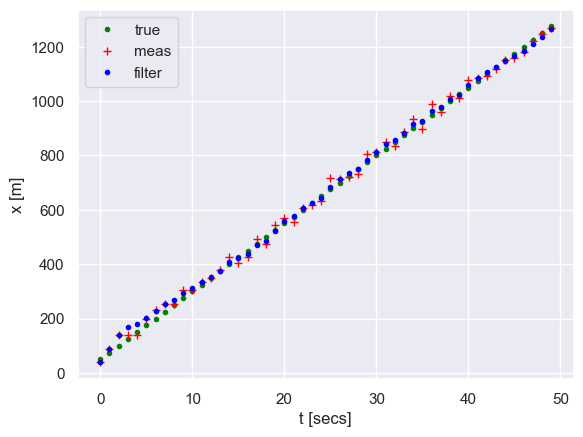

In [2]:
def filter_step(a, b, meas, dt, x_prev, V_prev):
    if (x_prev is None) and (V_prev is None): # first step of initialization
        return meas, None
    
    if V_prev is None:                        # second step of initialization
        return meas, (meas - x_prev) / dt

    x_pred = x_prev + (V_prev * dt)
    V_pred = V_prev
    
    x = x_pred + (a * (meas - x_pred))
    V = V_pred + ((b / dt) * (meas - x_pred))
    
    return x, V


number_steps = 50
x0 = 50.
V0 = 25.
dt = 1.
mu = 0.
std = 20.
true_arr = []
meas_arr = []
x_arr = []
V_arr = []

for i in range(number_steps):
    t = i * dt
    true = x0 + (V0*t)
    meas = true + np.random.normal(mu, std)
    
    true_arr.append(true)
    meas_arr.append(meas)

a = 0.4
b = 0.2
x_prev = None
V_prev = None
for i in range(number_steps):
    x, V = filter_step(a, b, meas_arr[i], dt, x_prev, V_prev)
    
    x_arr.append(x)
    V_arr.append(V)
    
    x_prev = x
    V_prev = V

plt.figure()
plt.xlabel('t [secs]')
plt.ylabel('x [m]')
plt.plot(true_arr, marker='.', linestyle='none', color='green', label='true'  ) 
plt.plot(meas_arr, marker='+', linestyle='none', color='red',   label='meas'  )
plt.plot(x_arr,    marker='.', linestyle='none', color='blue',  label='filter')
plt.legend(loc='upper left')
plt.show()

## Dymanic coefficients
The most honest way to determine the filter coefficients is to establish their dependence on the filtration step $k$.
In this case, the alpha and beta coefficients should be calculated using the following formulas:
$$
\alpha = \frac{2(2k-1)}{k(k+1)}
$$
$$
\beta = \frac{6}{k(k+1)}
$$
In this case, the alpha and beta coefficients quickly tend to zero, which means that the measurements are practically ignored. To avoid this, either a lower bound is set for each of the alpha and beta coefficients, or a value of $k_{max}$ is set after which $k$ is no longer increased.

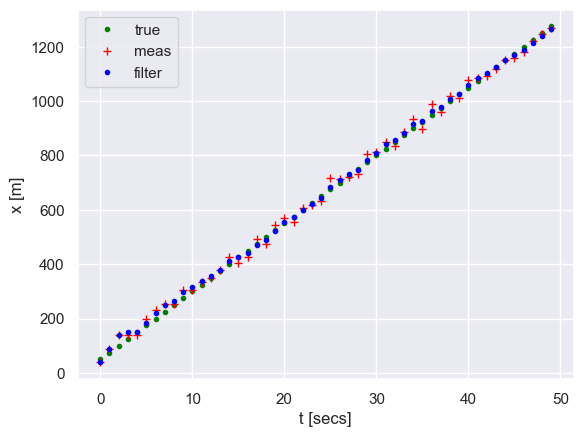

In [3]:
def filter_step(k, k_max, meas, dt, x_prev, V_prev):
    if (x_prev is None) and (V_prev is None): # first step of initialization
        return meas, None
    
    if V_prev is None:                        # second step of initialization
        return meas, (meas - x_prev) / dt

    if k > k_max:
        k = k_max
    
    a = 2.*(2. * k - 1.) / (k * (k + 1.))
    b = 6. / (k * (k + 1.))

    x_pred = x_prev + (V_prev*dt)
    V_pred = V_prev
    
    x = x_pred + (a * (meas - x_pred))
    V = V_pred + ((b / dt) * (meas - x_pred))
    
    return x, V

x_arr = []
V_arr = []
x_prev = None
V_prev = None
for i in range(number_steps):
    x, V = filter_step(i, 10, meas_arr[i], dt, x_prev, V_prev)
    
    x_arr.append(x)
    V_arr.append(V)
    
    x_prev = x
    V_prev = V

plt.figure()
plt.xlabel('t [secs]')
plt.ylabel('x [m]')
plt.plot(true_arr, marker='.', linestyle='none', color='green', label='true'  ) 
plt.plot(meas_arr, marker='+', linestyle='none', color='red',   label='meas'  )
plt.plot(x_arr,    marker='.', linestyle='none', color='blue',  label='filter')
plt.legend(loc='upper left')
plt.show()